In [47]:
import pandas as pd
import yfinance as yf


ticker = "EURUSD=X"
interval = "15m"
period = "60d"
data = yf.download(ticker, period=period, interval=interval)
data.to_csv("USDEUR.csv")

[*********************100%%**********************]  1 of 1 completed


In [48]:
data_from_csv = pd.read_csv("USDEUR.csv", index_col='Datetime', parse_dates=True)
df = data_from_csv[data_from_csv['Volume'] == 0]


In [49]:
import pandas_ta as ta

df["EMA15"] = ta.ema(df['Close'], length=15)
df["EMA30"] = ta.ema(df['Close'], length=30)
df["EMA50"] = ta.ema(df['Close'], length=50)
df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'])

In [50]:
import numpy as np

df['slopeEMA15'] = df['EMA15'].diff(periods=1).rolling(window=10).mean()
df['slopeEMA30'] = df['EMA30'].diff(periods=1).rolling(window=10).mean()
df['slopeEMA50'] = df['EMA50'].diff(periods=1).rolling(window=10).mean()
conditions = [
    (df['EMA15'] < df['EMA30']) & (df['EMA30'] < df['EMA50']) & (df['slopeEMA15'] < 0) & (df['slopeEMA30'] < 0) & (df['slopeEMA50'] < 0),
    (df['EMA15'] > df['EMA30']) & (df['EMA30'] > df['EMA50']) & (df['slopeEMA15'] > 0) & (df['slopeEMA30'] > 0) & (df['slopeEMA50'] > 0)
]
choices = [1, 2]
df['EMAsignal'] = np.select(conditions, choices, default=0)

In [51]:
TotSignal = [0] * len(df)
wicklimit = 2e-5
for row in range(len(df)):
    if df['EMAsignal'][row] == 1 and df['Open'][row] > df['EMA15'][row] and df.Close[row] < df.EMA15[row] and df['High'][row] - df['Open'][row] <= wicklimit:
        TotSignal[row] = 1
    if df['EMAsignal'][row] == 2 and df['Open'][row] < df['EMA15'][row] and df.Close[row] < df.EMA15[row] and df['Open'][row] - df['Low'][row] <= wicklimit:
        TotSignal[row] = 2
df['TotSignal'] = TotSignal

C:\Users\User\AppData\Local\Temp\ipykernel_3844\1551769615.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['EMAsignal'][row] == 1 and df['Open'][row] > df['EMA15'][row] and df.Close[row] < df.EMA15[row] and df['High'][row] - df['Open'][row] <= wicklimit:
C:\Users\User\AppData\Local\Temp\ipykernel_3844\1551769615.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['EMAsignal'][row] == 2 and df['Open'][row] < df['EMA15'][row] and df.Close[row] < df.EMA15[row] and df['Open'][row] - df['Low'][row] <= wicklimit:


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mplfinance\plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)


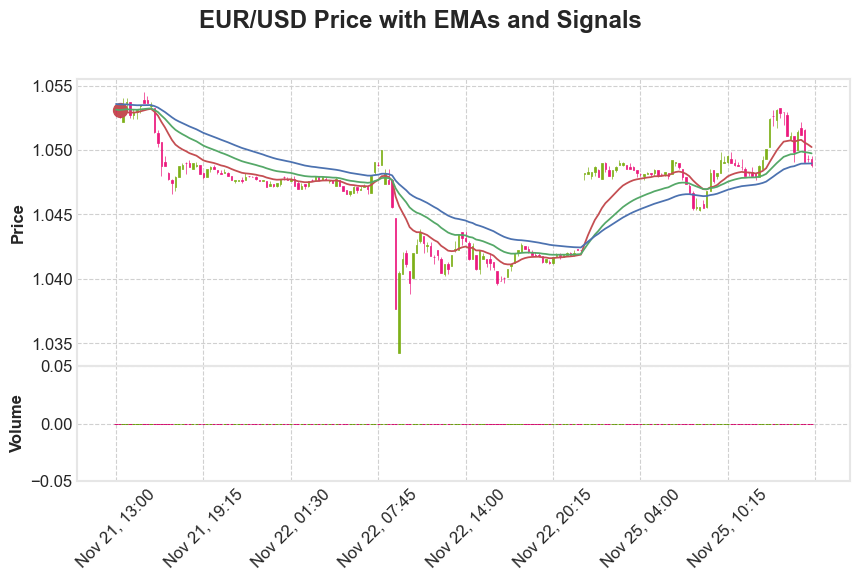

In [52]:
import mplfinance as mpf

def pointpos(x):
    if x['TotSignal'] == 1:
        return x['High']
    elif x['TotSignal'] == 2:
        return x['Low']
    else:
        return np.nan
df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
dfpl = df[1000:1200]
apdict = [
    mpf.make_addplot(dfpl['EMA15'], color='r'),
    mpf.make_addplot(dfpl['EMA30'], color='g'),
    mpf.make_addplot(dfpl['EMA50'], color='b'),
    mpf.make_addplot(dfpl['pointpos'], type='scatter', markersize=100, marker='o', color='r')
]
mpf.plot(dfpl, type='candle', addplot=apdict, volume=True, title='EUR/USD Price with EMAs and Signals', figratio=(28, 15), style='binance')


In [53]:
capital = 2000
slippage = 0
signal = ""
trd = pd.DataFrame(columns=["Signal", "Entry time", "Buy Price", "Quantity", "Exit time", "Sell price", 'Points', "Profit", "Capital"])
cur_cap = capital
position_open = False
for i in range(len(df)):
    cc = df.iloc[i]
    if signal == "":
        if cc['TotSignal'] == 1 and not position_open:
            signal = "buy"
            buy_pri = cc['close'] + cc['close'] * slippage
            sl = cc['close'] - 30e-4
            tar = cc['close'] + 50e-4
            entry_time = cc.name
            quantity = round(cur_cap / cc['close'] / 25) * 25
            position_open = True
        elif cc['TotSignal'] == 2 and not position_open:
            signal = "sell"
            sell_pri = cc['close'] + cc['close'] * slippage
            sl = cc['close'] + 30e-4
            tar = cc['close'] - 50e-4
            entry_time = cc.name
            quantity = round(cur_cap / cc['close'] / 25) * 25
            position_open = True
    elif signal == "buy" and position_open:
        if cc['high'] > tar or cc['low'] < sl:
            exit_time = cc.name
            sq = tar if cc['high'] > tar else sl
            pt = sq - buy_pri
            pro = (sq - buy_pri) * quantity
            cur_cap = cur_cap + pro
            trd.loc[len(trd.index)] = [signal, entry_time, buy_pri, quantity, exit_time, sq, pt, pro, cur_cap]
            signal = ""
            position_open = False
    elif signal == "sell" and position_open:
        if cc['high'] > sl or cc['low'] < tar:
            exit_time = cc.name
            sq = sl if cc['high'] > sl else tar
            pt = sell_pri - sq
            pro = (sell_pri - sq) * quantity
            cur_cap = cur_cap + pro
            trd.loc[len(trd.index)] = [signal, entry_time, sell_pri, quantity, exit_time, sq, pt, pro, cur_cap]
            signal = ""
            position_open = False

In [54]:
print(trd.tail()) 

max_profit = trd["Profit"].max()
max_loss = trd["Profit"].min()

print(f"Maximum Profit in a Single Trade: ${max_profit:.2f}")
print(f"Maximum Loss in a Single Trade: ${max_loss:.2f}")



   Signal          Entry time  Buy Price  Quantity           Exit time  \
38   sell 2025-01-22 12:30:00   1.044059      1900 2025-01-23 16:00:00   
39   sell 2025-01-24 11:45:00   1.048768      1900 2025-01-24 15:45:00   
40    buy 2025-01-27 06:30:00   1.046244      1900 2025-01-27 11:00:00   
41   sell 2025-01-27 15:15:00   1.050751      1900 2025-01-27 23:15:00   
42    buy 2025-01-28 10:45:00   1.042753      1925 2025-01-29 12:15:00   

    Sell price  Points  Profit   Capital  
38    1.039059   0.005   9.500  1989.400  
39    1.051768  -0.003  -5.700  1983.700  
40    1.051244   0.005   9.500  1993.200  
41    1.045751   0.005   9.500  2002.700  
42    1.039753  -0.003  -5.775  1996.925  
Maximum Profit in a Single Trade: $9.62
Maximum Loss in a Single Trade: $-5.85


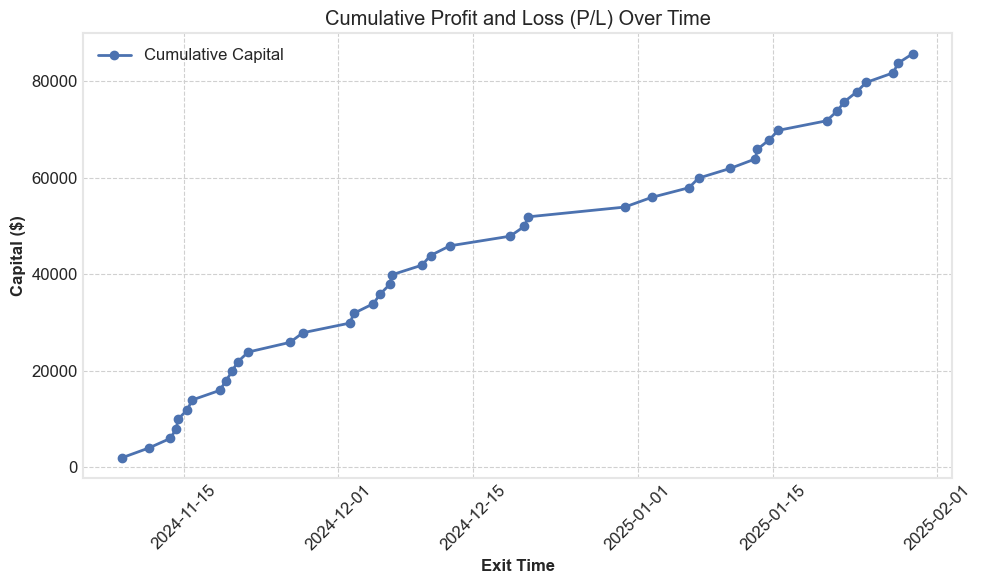

In [55]:
import matplotlib.pyplot as plt


trd['Cumulative Capital'] = trd['Capital'].cumsum()


plt.figure(figsize=(10,6))
plt.plot(trd['Exit time'], trd['Cumulative Capital'], label='Cumulative Capital', color='b', marker='o')
plt.title('Cumulative Profit and Loss (P/L) Over Time')
plt.xlabel('Exit Time')
plt.ylabel('Capital ($)')
plt.grid(True)
plt.legend(loc='upper left')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()
